# CURVA ROC / AUC
A Curva ROC é uma curva que de forma muito simplista e fácil de se avaliar serve para avaliar a performance de um modelo preditivo de classificação, onde é muito importante medir a Sensibilidade do modelo. Ela é aplicada em modelos de Regressão Logística Binária.

In [2]:
#Pacotes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [4]:
df_original = pd.read_csv('heart.csv')
df_original.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
# Convertendo as variaveis do tipo Object para Category
df_original['Sex'] = df_original['Sex'].astype('category')
df_original['ChestPainType'] = df_original['ChestPainType'].astype('category')
df_original['RestingECG'] = df_original['RestingECG'].astype('category')
df_original['ExerciseAngina'] = df_original['ExerciseAngina'].astype('category')
df_original['ST_Slope'] = df_original['ST_Slope'].astype('category')
df_original['FastingBS'] = df_original['FastingBS'].astype('category')

# carregar variaveis categoricas para OneHotEncoding
# Vamos colocar o slice somente até a coluna de indice 18 para não pegar a variável target.
variaveis_categoricas = []
for i in df_original.columns[0:11].tolist():
        if df_original.dtypes[i] == 'object' or df_original.dtypes[i] == 'category':                        
            variaveis_categoricas.append(i) 
            

# Cria o encoder e aplica OneHotEncoder
lb = LabelEncoder()

for var in variaveis_categoricas:
    df_original[var] = lb.fit_transform(df_original[var])
    
    
#Separar variaveis preditoras e target
PREDITORAS = df_original.iloc[:, 0:11]  
TARGET = df_original.iloc[:, 11] 


# Seed para reproduzir o mesmo resultado
seed = 100

# Cria o balanceador SMOTE
balanceador = SMOTE(random_state = seed)

# Aplica o balanceador
PREDITORAS_RES, TARGET_RES = balanceador.fit_resample(PREDITORAS, TARGET)


# Divisão em Dados de Treino e Teste.
X_treino, X_teste, Y_treino, Y_teste = train_test_split(PREDITORAS_RES, TARGET_RES, test_size = 0.3, random_state = 42)


# Normalização das Variáveis
Normalizador = MinMaxScaler()
X_treino_normalizados = Normalizador.fit_transform(X_treino)
X_teste_normalizados = Normalizador.transform(X_teste)

In [10]:
# Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators  = 300, criterion = 'entropy', max_depth = 10, 
                             max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_jobs = 8)

# Construção do modelo
clf = clf.fit(X_treino_normalizados, Y_treino)

# Previsoes do modelo
previsoes = clf.predict(X_teste_normalizados)

In [12]:
# Criamos uma confusion matrix
cm = confusion_matrix(Y_teste, previsoes)
print(cm)

[[120  18]
 [ 20 147]]


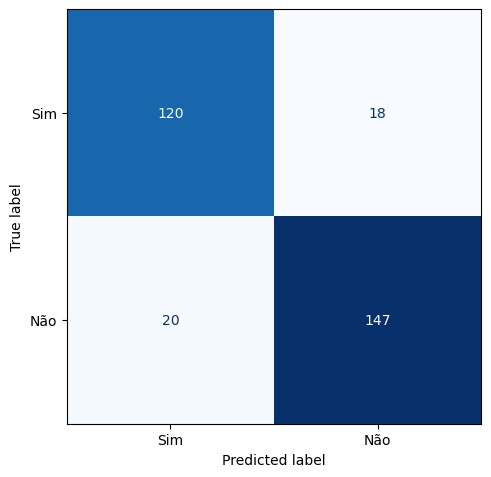

In [14]:
# Gerando o plot da confusion matrix
cm_disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Sim","Não"])
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
cm_disp.plot(include_values=True, 
             cmap='Blues',              
             colorbar=None)
plt.show()

In [16]:
TRP = cm[0][0] + cm[1][1] 
FPR = cm[0][1] + cm[1][0] 

print('TPR: ', TRP)
print('FRP: ', FPR)

TPR:  267
FRP:  38


In [18]:
# Como a Curva ROC é calculada
# No eixo X (Horizontal) é a taxa de falso positivo (FPR)
# No eixo Y (Vertical) é a taxa de verdadeiro positivo (TPR)

#from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Criando o modelo com Random Forest
modelo_RFC = RandomForestClassifier(n_estimators  = 300, criterion = 'entropy', max_depth = 10, 
                             max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_jobs = 8)


# Criando o modelo com KNN
modelo_KNN = KNeighborsClassifier(n_neighbors=4)


# Treinando os modelos
modelo_RFC.fit(X_treino_normalizados, Y_treino)
modelo_KNN.fit(X_treino_normalizados, Y_treino)


# Gerando as probabilidades
pred_prob_RFC = modelo_RFC.predict_proba(X_teste_normalizados)
pred_prob_KNN = modelo_KNN.predict_proba(X_teste_normalizados)

In [20]:
# Atribuindo os valores as variaveis
frp1, tpr1, thresh1 = roc_curve(Y_teste, pred_prob_RFC[:,1], pos_label = 1)
frp2, tpr2, thresh2 = roc_curve(Y_teste, pred_prob_KNN[:,1], pos_label = 1)

# Fazendo um loop for com as probabilidades
random_probs = [0 for i in range(len(Y_teste))]
p_fpr, p_tpr, _ = roc_curve(Y_teste, random_probs, pos_label = 1)

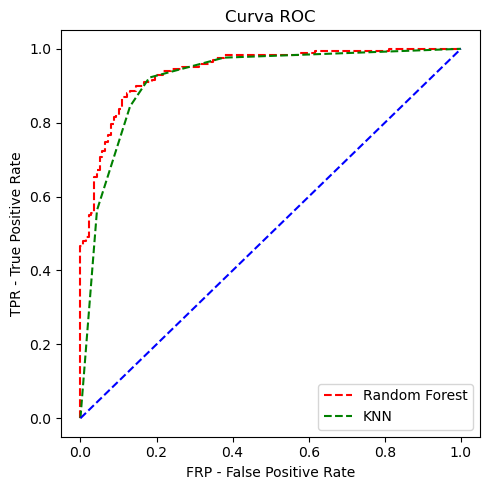

In [22]:
# Gerando o gráfico da Curva ROC
plt.plot(frp1,tpr1, linestyle = '--', color = 'red', label = 'Random Forest')
plt.plot(frp2,tpr2, linestyle = '--', color = 'green', label = 'KNN')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')

plt.title('Curva ROC')
plt.xlabel('FRP - False Positive Rate')
plt.ylabel('TPR - True Positive Rate')

plt.legend(loc = 'best')
plt.show()

In [24]:
# AUC Score - Area Under Curve - Area Abaixo da Curva
print('AUC Score RFC: ', roc_auc_score(Y_teste, pred_prob_RFC[:,1]))
print('AUC Score KNN: ', roc_auc_score(Y_teste, pred_prob_KNN[:,1]))

AUC Score RFC:  0.9412479389047991
AUC Score KNN:  0.9196389829037578


Fim